# `CNModel` Hyperfine Anomalies

Trey V. Wenger (c) March 2025

`CNModel` can also account for a full physical treatment of non-LTE effects. That is, it can model situations where the excitation temperature is *not* the same for each transition. `CNModel` considers the detailed balance between all transitions in the `mol_data` dictionary. For ${\rm CN}$ this includes all of the $N=1-0$ ($\nu = 0$) hyperfine transitions at 113.15 and 113.5 GHz, and for $^{13}{\rm CN}$ this includes all of the $N=1-0$ hyperfine transitions at 108.06 GHz, 108.4 GHz, 108.6 GHz, 108.8 GHz, and 109.2 GHz. Each state column density is a free parameter, and the relative state column densities are set by the excitation temperature. Since there are more transitions than states, this is an overconstrained problem and easy for a Bayesian forward model to solve.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("arviz version:", az.__version__)

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

arviz version: 0.22.0dev
pymc version: 5.21.1
bayes_spec version: 1.7.4
bayes_cn_hfs version: 1.1.1+6.g94944ab.dirty


## Simulate data

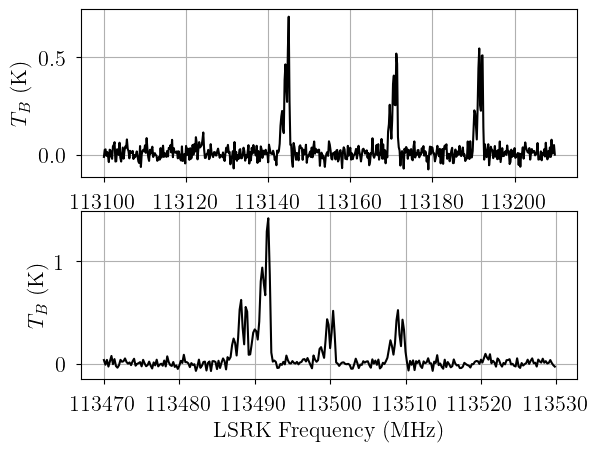

In [2]:
from bayes_cn_hfs import supplement_mol_data
from bayes_spec import SpecData
from bayes_cn_hfs.cn_model import CNModel

mol_data_12CN, mol_weight_12CN = supplement_mol_data("CN")

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# CNModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.75, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.5, 0.1], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.1], # mean and width of log10 excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N": [13.8, 13.9, 14.0],
    "log10_Tkin": [0.65, 0.6, 0.5],
    "fwhm_nonthermal": [1.0, 1.25, 1.5],
    "velocity": [-2.0, 0.0, 2.5],
    "fwhm_L": 0.0,
    "log10_Tex_ul": [0.65, 0.6, 0.5],
    "LTE_precision": [1.0e-3, 1.0e-4, 1.0e-5],
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

In [3]:
sim_params

{'log10_N': [13.8, 13.9, 14.0],
 'log10_Tkin': [0.65, 0.6, 0.5],
 'fwhm_nonthermal': [1.0, 1.25, 1.5],
 'velocity': [-2.0, 0.0, 2.5],
 'fwhm_L': 0.0,
 'log10_Tex_ul': [0.65, 0.6, 0.5],
 'LTE_precision': [0.001, 0.0001, 1e-05],
 'baseline_12CN-1_norm': [0.0],
 'baseline_12CN-2_norm': [0.0],
 'fwhm_thermal': array([0.08867757, 0.08371703, 0.07461288]),
 'fwhm': array([1.00392416, 1.25280028, 1.50185455]),
 'Tex': array([[5.32209501, 3.90739658, 3.17678715],
        [4.98975014, 3.9748294 , 3.14452298],
        [4.35529943, 3.84778722, 3.1908251 ],
        [4.13039793, 3.91314346, 3.15828662],
        [4.24671721, 4.11289346, 3.18902146],
        [4.88183041, 4.06157415, 3.14595138],
        [4.28187157, 3.950381  , 3.13645064],
        [4.03320087, 4.18738661, 3.15660997],
        [4.06491045, 4.01907645, 3.10510575]]),
 'tau': array([[0.02400442, 0.0403725 , 0.06234188],
        [0.2180944 , 0.32023025, 0.52137245],
        [0.21384004, 0.32504816, 0.49755831],
        [0.30506202, 0.40

## Model Definition

We fix the kinetic temperature because we can't measure the thermal line width.

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
obs_1 = SpecData(
    freq_axis_1,
    sim_obs1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    sim_obs2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {"12CN-1": obs_1, "12CN-2": obs_2}

# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.75, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.5, 0.1], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.1], # mean and width of log10 excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, log10_Tkin_norm, velocity_norm, weights]


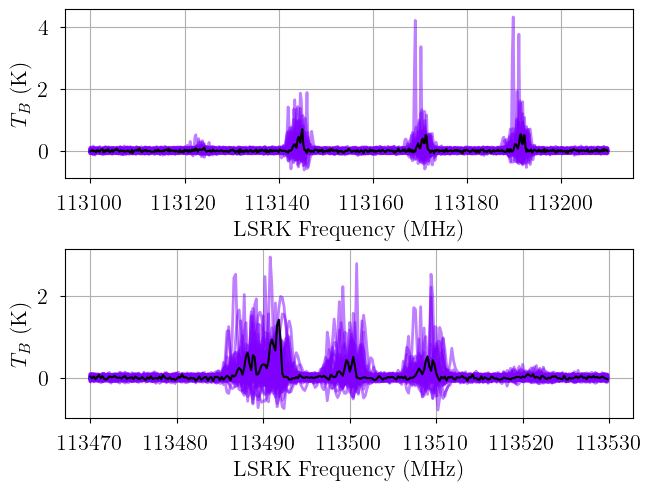

In [5]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

baseline_freeRVs ['baseline_12CN-1_norm', 'baseline_12CN-2_norm']
baseline_deterministics []
cloud_freeRVs ['velocity_norm', 'log10_Tkin_norm', 'fwhm_nonthermal_norm', 'log10_N_norm', 'log10_Tex_ul_norm', 'LTE_precision', 'weights']
cloud_deterministics ['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'Tex', 'tau', 'tau_total', 'TR']
hyper_freeRVs ['fwhm_L_norm']
hyper_deterministics ['fwhm_L']


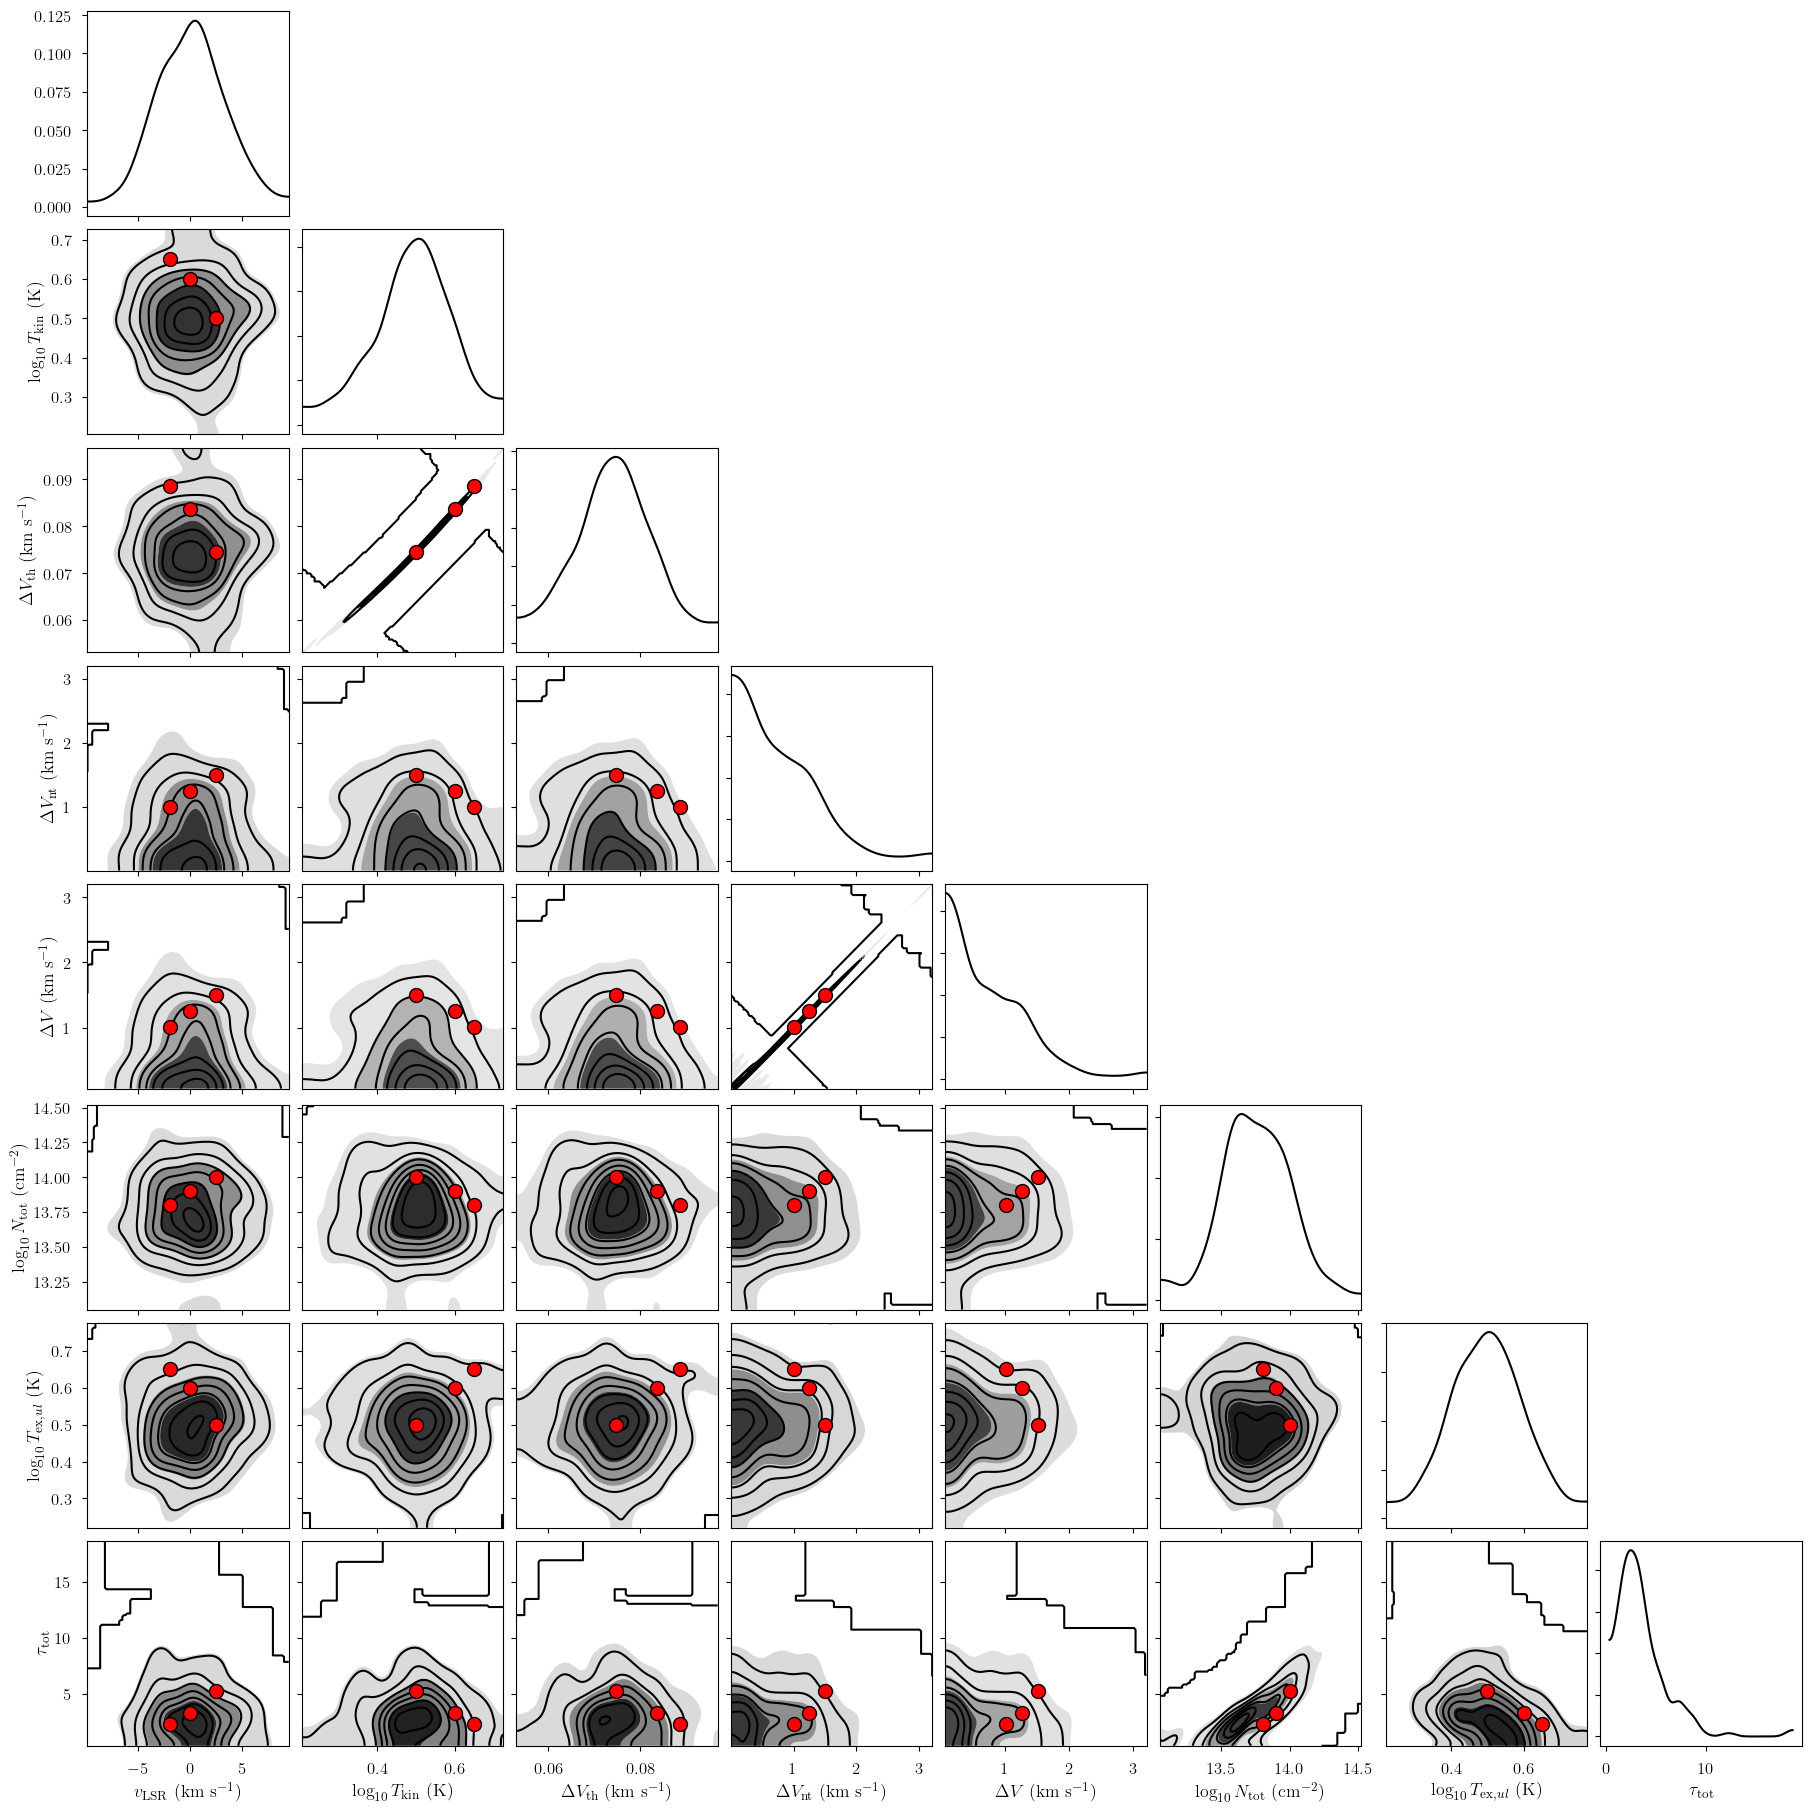

In [6]:
from bayes_spec.plots import plot_pair

# available parameter attributes:
print("baseline_freeRVs", model.baseline_freeRVs)
print("baseline_deterministics", model.baseline_deterministics)
print("cloud_freeRVs", model.cloud_freeRVs)
print("cloud_deterministics", model.cloud_deterministics)
print("hyper_freeRVs", model.hyper_freeRVs)
print("hyper_deterministics", model.hyper_deterministics)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

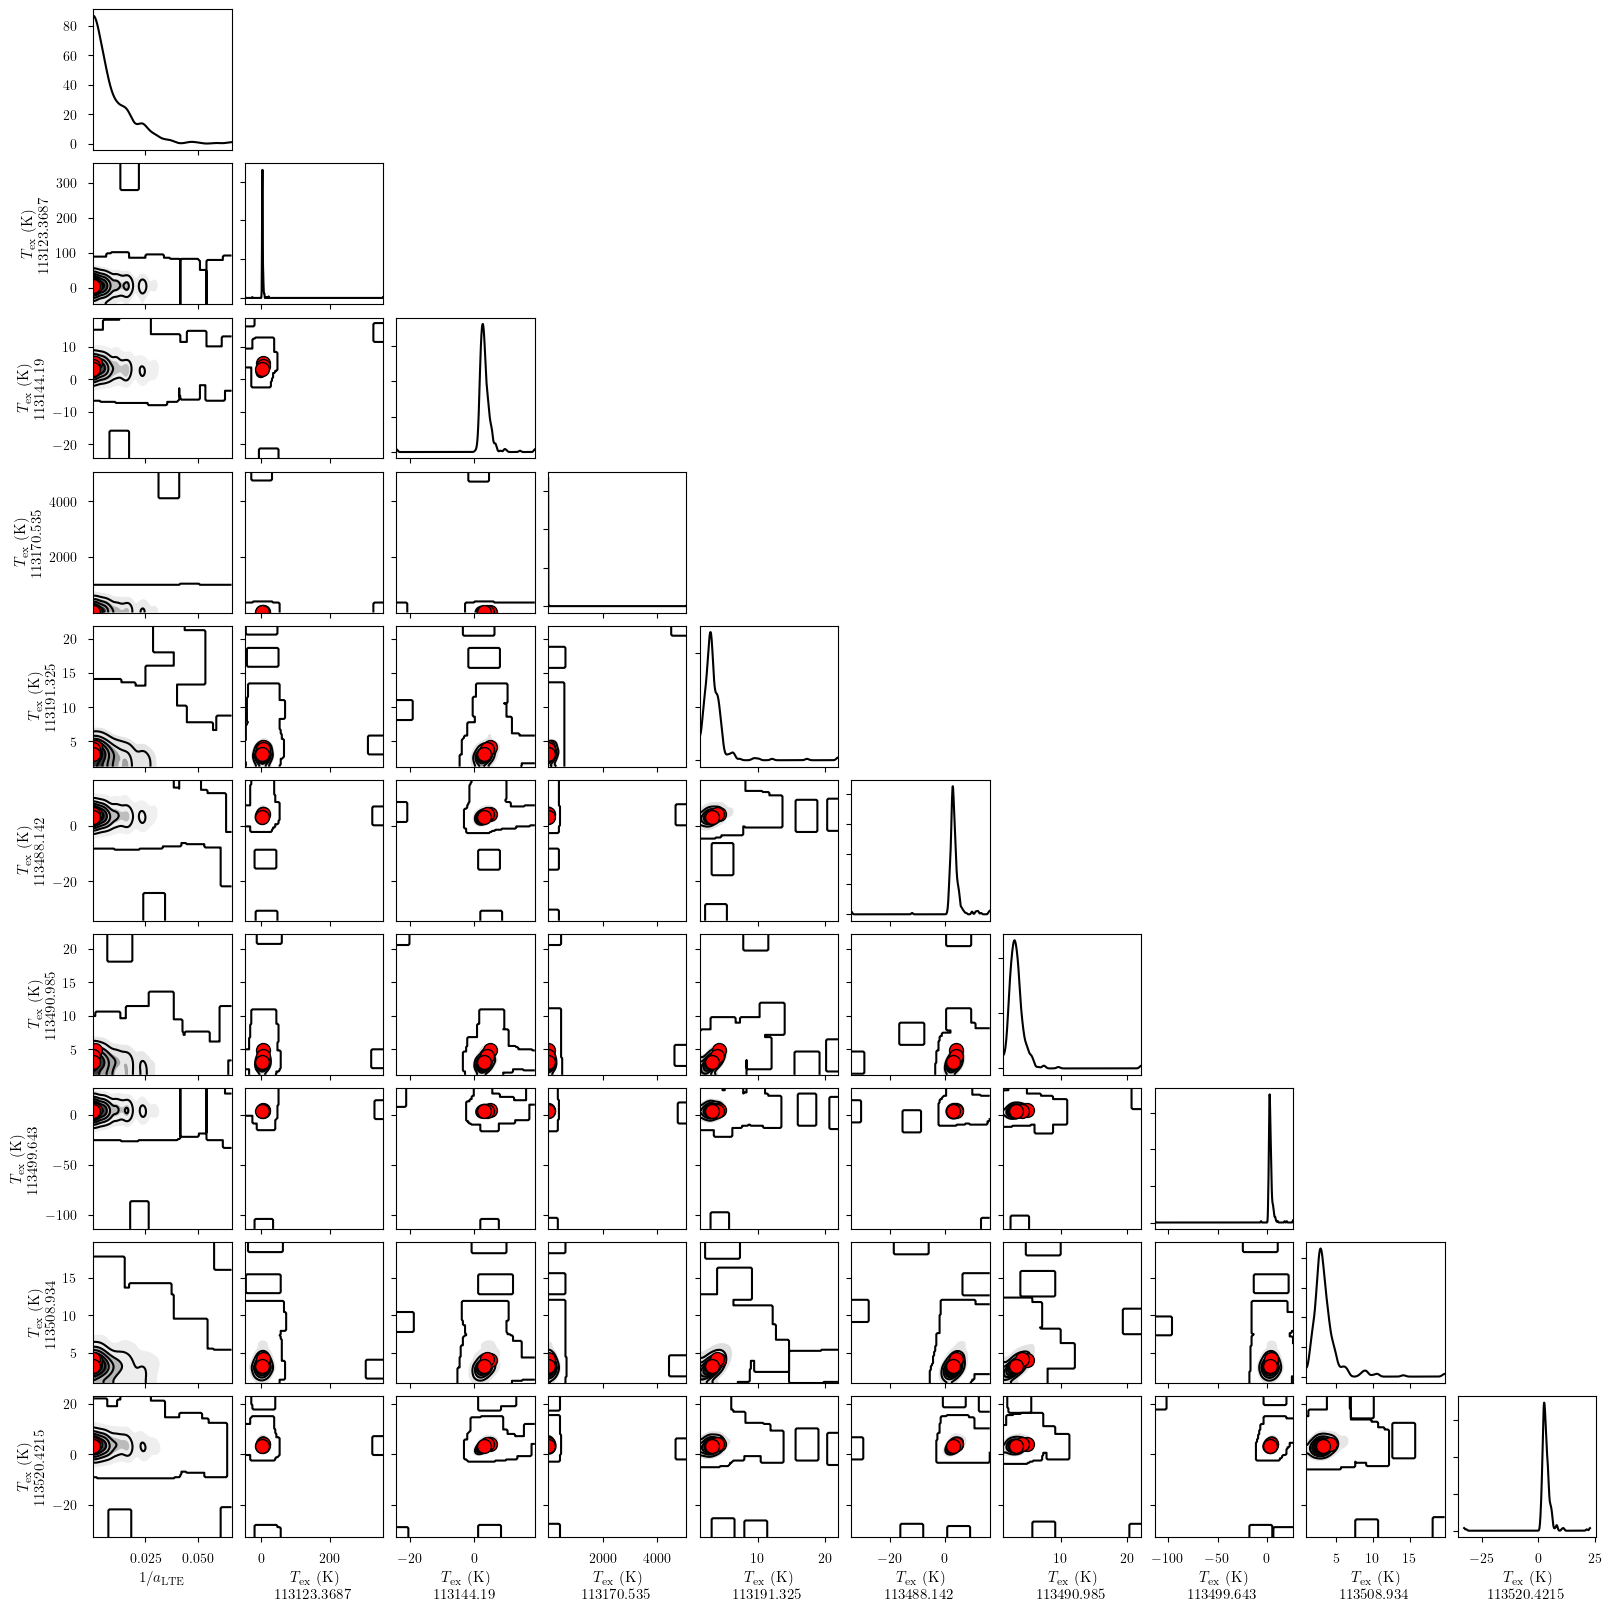

In [7]:
axes = plot_pair(
    prior.prior, # samples
    ['LTE_precision', 'Tex'], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)
axes.ravel()[0].figure.set_size_inches(16, 16)

## Variational Inference

In [12]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 10600
Interrupted at 10,599 [10%]: Average Loss = 15,049


Output()

Runtime: 0.44 minutes


In [13]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]               2.527  0.036   2.466    2.598      0.001    0.001   
velocity[1]               0.011  0.015  -0.019    0.037      0.001    0.000   
velocity[2]              -1.981  0.009  -1.999   -1.963      0.000    0.000   
log10_Tkin[0]             0.493  0.107   0.292    0.694      0.003    0.002   
log10_Tkin[1]             0.504  0.105   0.322    0.710      0.004    0.002   
log10_Tkin[2]             0.486  0.104   0.300    0.693      0.003    0.002   
fwhm_thermal[0]           0.075  0.009   0.058    0.093      0.000    0.000   
fwhm_thermal[1]           0.076  0.009   0.059    0.092      0.000    0.000   
fwhm_thermal[2]           0.074  0.009   0.058    0.092      0.000    0.000   
fwhm_nonthermal[0]        1.544  0.077   1.392    1.681      0.003    0.002   
fwhm_nonthermal[1]        1.271  0.034   1.211    1.337      0.001    0.001   
fwhm_nonthermal[2]        0.899  0.021   0.859    0.940      0.001    0.000   
fwhm[0]                   1.546  0.077   1.394    1.683      0.003    0.002   
fwhm[1]                   1.273  0.034   1.212    1.337      0.001    0.001   
fwhm[2]                   0.902  0.021   0.862    0.942      0.001    0.000   
log10_N[0]               13.683  0.018  13.649   13.716      0.001    0.000   
log10_N[1]               13.855  0.009  13.839   13.872      0.000    0.000   
log10_N[2]               13.953  0.010  13.935   13.972      0.000    0.000   
log10_Tex_ul[0]           0.543  0.014   0.515    0.568      0.000    0.000   
log10_Tex_ul[1]           0.618  0.011   0.597    0.637      0.000    0.000   
log10_Tex_ul[2]           0.601  0.035   0.539    0.667      0.001    0.001   
tau_total[0]              2.240  0.095   2.053    2.402      0.003    0.002   
tau_total[1]              2.827  0.062   2.713    2.945      0.002    0.001   
tau_total[2]              3.666  0.084   3.508    3.820      0.003    0.002   
fwhm_L                    0.065  0.032   0.020    0.125      0.001    0.001   
baseline_12CN-1_norm[0]  -0.115  0.042  -0.193   -0.039      0.001    0.001   
baseline_12CN-2_norm[0]  -0.357  0.065  -0.481   -0.237      0.002    0.001   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                 944.0     909.0    NaN  
velocity[1]                 743.0     875.0    NaN  
velocity[2]                1059.0     901.0    NaN  
log10_Tkin[0]               953.0     884.0    NaN  
log10_Tkin[1]               868.0     911.0    NaN  
log10_Tkin[2]              1028.0     894.0    NaN  
fwhm_thermal[0]             953.0     884.0    NaN  
fwhm_thermal[1]             868.0     911.0    NaN  
fwhm_thermal[2]            1028.0     894.0    NaN  
fwhm_nonthermal[0]          947.0     838.0    NaN  
fwhm_nonthermal[1]          951.0     944.0    NaN  
fwhm_nonthermal[2]          982.0    1026.0    NaN  
fwhm[0]                     946.0     838.0    NaN  
fwhm[1]                     952.0     944.0    NaN  
fwhm[2]                     982.0    1024.0    NaN  
log10_N[0]                  904.0     789.0    NaN  
log10_N[1]                 1059.0     978.0    NaN  
log10_N[2]                  956.0     981.0    NaN  
log10_Tex_ul[0]             929.0     903.0    NaN  
log10_Tex_ul[1]            1039.0    1060.0    NaN  
log10_Tex_ul[2]            1011.0     901.0    NaN  
tau_total[0]                890.0     815.0    NaN  
tau_total[1]               1056.0     941.0    NaN  
tau_total[2]               1008.0     980.0    NaN  
fwhm_L                      848.0     941.0    NaN  
baseline_12CN-1_norm[0]     840.0     942.0    NaN  
baseline_12CN-2_norm[0]     801.0     713.0    NaN

Sampling: [12CN-1, 12CN-2]


Output()

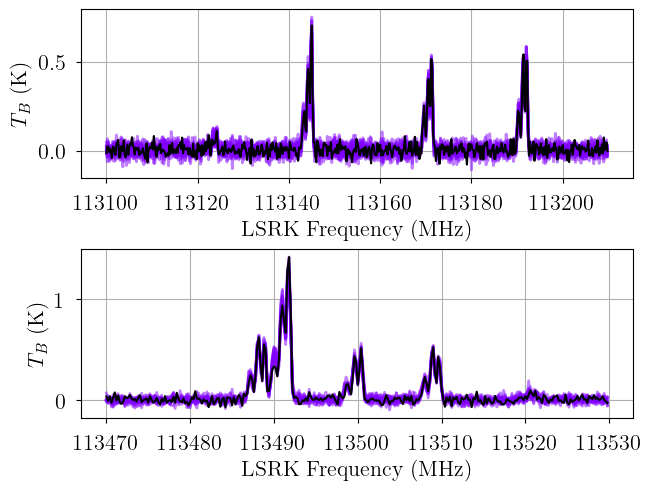

In [14]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

In [15]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.02}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 10600
Interrupted at 10,599 [10%]: Average Loss = 15,049
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 268 seconds.


Adding log-likelihood to trace


Output()

There were 288 divergences in converged chains.
Runtime: 5.10 minutes


In [16]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution
7 of 8 chains appear converged.


Sampling: [12CN-1, 12CN-2]


Output()

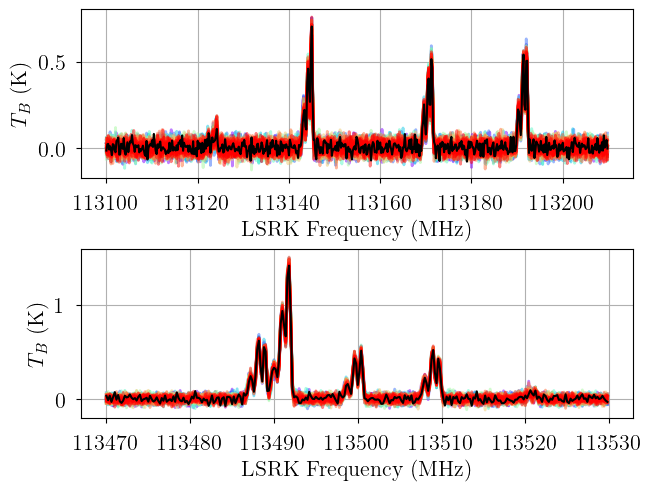

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [18]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
] + ['Tex']
pm.summary(model.trace.solution_0, var_names=var_names + model.hyper_freeRVs + model.baseline_freeRVs)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]               2.527  0.034   2.466    2.593      0.000    0.000   
velocity[1]              -0.004  0.015  -0.031    0.024      0.000    0.000   
velocity[2]              -1.990  0.010  -2.010   -1.972      0.000    0.000   
log10_Tkin[0]             0.500  0.100   0.314    0.689      0.001    0.001   
log10_Tkin[1]             0.499  0.101   0.308    0.685      0.001    0.001   
log10_Tkin[2]             0.502  0.102   0.316    0.690      0.001    0.001   
fwhm_thermal[0]           0.075  0.009   0.059    0.091      0.000    0.000   
fwhm_thermal[1]           0.075  0.009   0.059    0.091      0.000    0.000   
fwhm_thermal[2]           0.075  0.009   0.060    0.093      0.000    0.000   
fwhm_nonthermal[0]        1.422  0.122   1.204    1.662      0.003    0.002   
fwhm_nonthermal[1]        1.264  0.053   1.164    1.364      0.001    0.001   
fwhm_nonthermal[2]        0.887  0.044   0.800    0.965      0.001    0.001   
fwhm[0]                   1.424  0.122   1.202    1.659      0.003    0.002   
fwhm[1]                   1.266  0.053   1.166    1.365      0.001    0.001   
fwhm[2]                   0.891  0.044   0.804    0.969      0.001    0.001   
log10_N[0]               13.911  0.147  13.636   14.188      0.005    0.005   
log10_N[1]               13.889  0.064  13.762   14.003      0.002    0.001   
log10_N[2]               13.964  0.053  13.862   14.064      0.001    0.001   
log10_Tex_ul[0]           0.512  0.024   0.476    0.556      0.001    0.001   
log10_Tex_ul[1]           0.610  0.023   0.571    0.655      0.001    0.001   
log10_Tex_ul[2]           0.600  0.037   0.529    0.670      0.001    0.001   
tau_total[0]              4.438  1.584   1.559    7.390      0.045    0.029   
tau_total[1]              3.171  0.598   2.042    4.277      0.014    0.011   
tau_total[2]              3.752  0.556   2.696    4.795      0.013    0.008   
Tex[113123.3687, 0]       3.343  0.282   3.032    3.791      0.011    0.030   
Tex[113123.3687, 1]       4.092  0.249   3.659    4.532      0.006    0.009   
Tex[113123.3687, 2]       4.480  0.251   4.059    4.940      0.006    0.006   
Tex[113144.19, 0]         3.319  0.241   3.024    3.700      0.010    0.023   
Tex[113144.19, 1]         4.111  0.240   3.710    4.548      0.006    0.010   
Tex[113144.19, 2]         4.207  0.173   3.916    4.535      0.004    0.004   
Tex[113170.535, 0]        3.293  0.238   3.022    3.663      0.010    0.025   
Tex[113170.535, 1]        3.973  0.208   3.627    4.362      0.005    0.007   
Tex[113170.535, 2]        3.932  0.150   3.673    4.204      0.003    0.004   
Tex[113191.325, 0]        3.270  0.204   3.014    3.595      0.008    0.019   
Tex[113191.325, 1]        3.992  0.203   3.643    4.351      0.005    0.008   
Tex[113191.325, 2]        3.722  0.104   3.542    3.913      0.002    0.002   
Tex[113488.142, 0]        3.291  0.233   3.025    3.663      0.009    0.025   
Tex[113488.142, 1]        4.223  0.252   3.809    4.686      0.007    0.010   
Tex[113488.142, 2]        3.786  0.127   3.567    4.026      0.003    0.003   
Tex[113490.985, 0]        3.234  0.112   3.095    3.410      0.004    0.010   
Tex[113490.985, 1]        4.115  0.129   3.895    4.338      0.003    0.005   
Tex[113490.985, 2]        4.562  0.083   4.422    4.715      0.002    0.002   
Tex[113499.643, 0]        3.153  0.175   2.923    3.438      0.007    0.015   
Tex[113499.643, 1]        3.969  0.212   3.618    4.366      0.006    0.007   
Tex[113499.643, 2]        3.814  0.140   3.581    4.080      0.003    0.003   
Tex[113508.934, 0]        3.270  0.203   3.016    3.607      0.008    0.019   
Tex[113508.934, 1]        4.244  0.251   3.832    4.683      0.007    0.011   
Tex[113508.934, 2]        3.592  0.092   3.428    3.765      0.002    0.002   
Tex[113520.4215, 0]       3.134  0.158   2.904    3.395      0.005    0.011   
Tex[113520.4215, 1]       3.989  0.217   3.615    4.374      0.006    0.008  

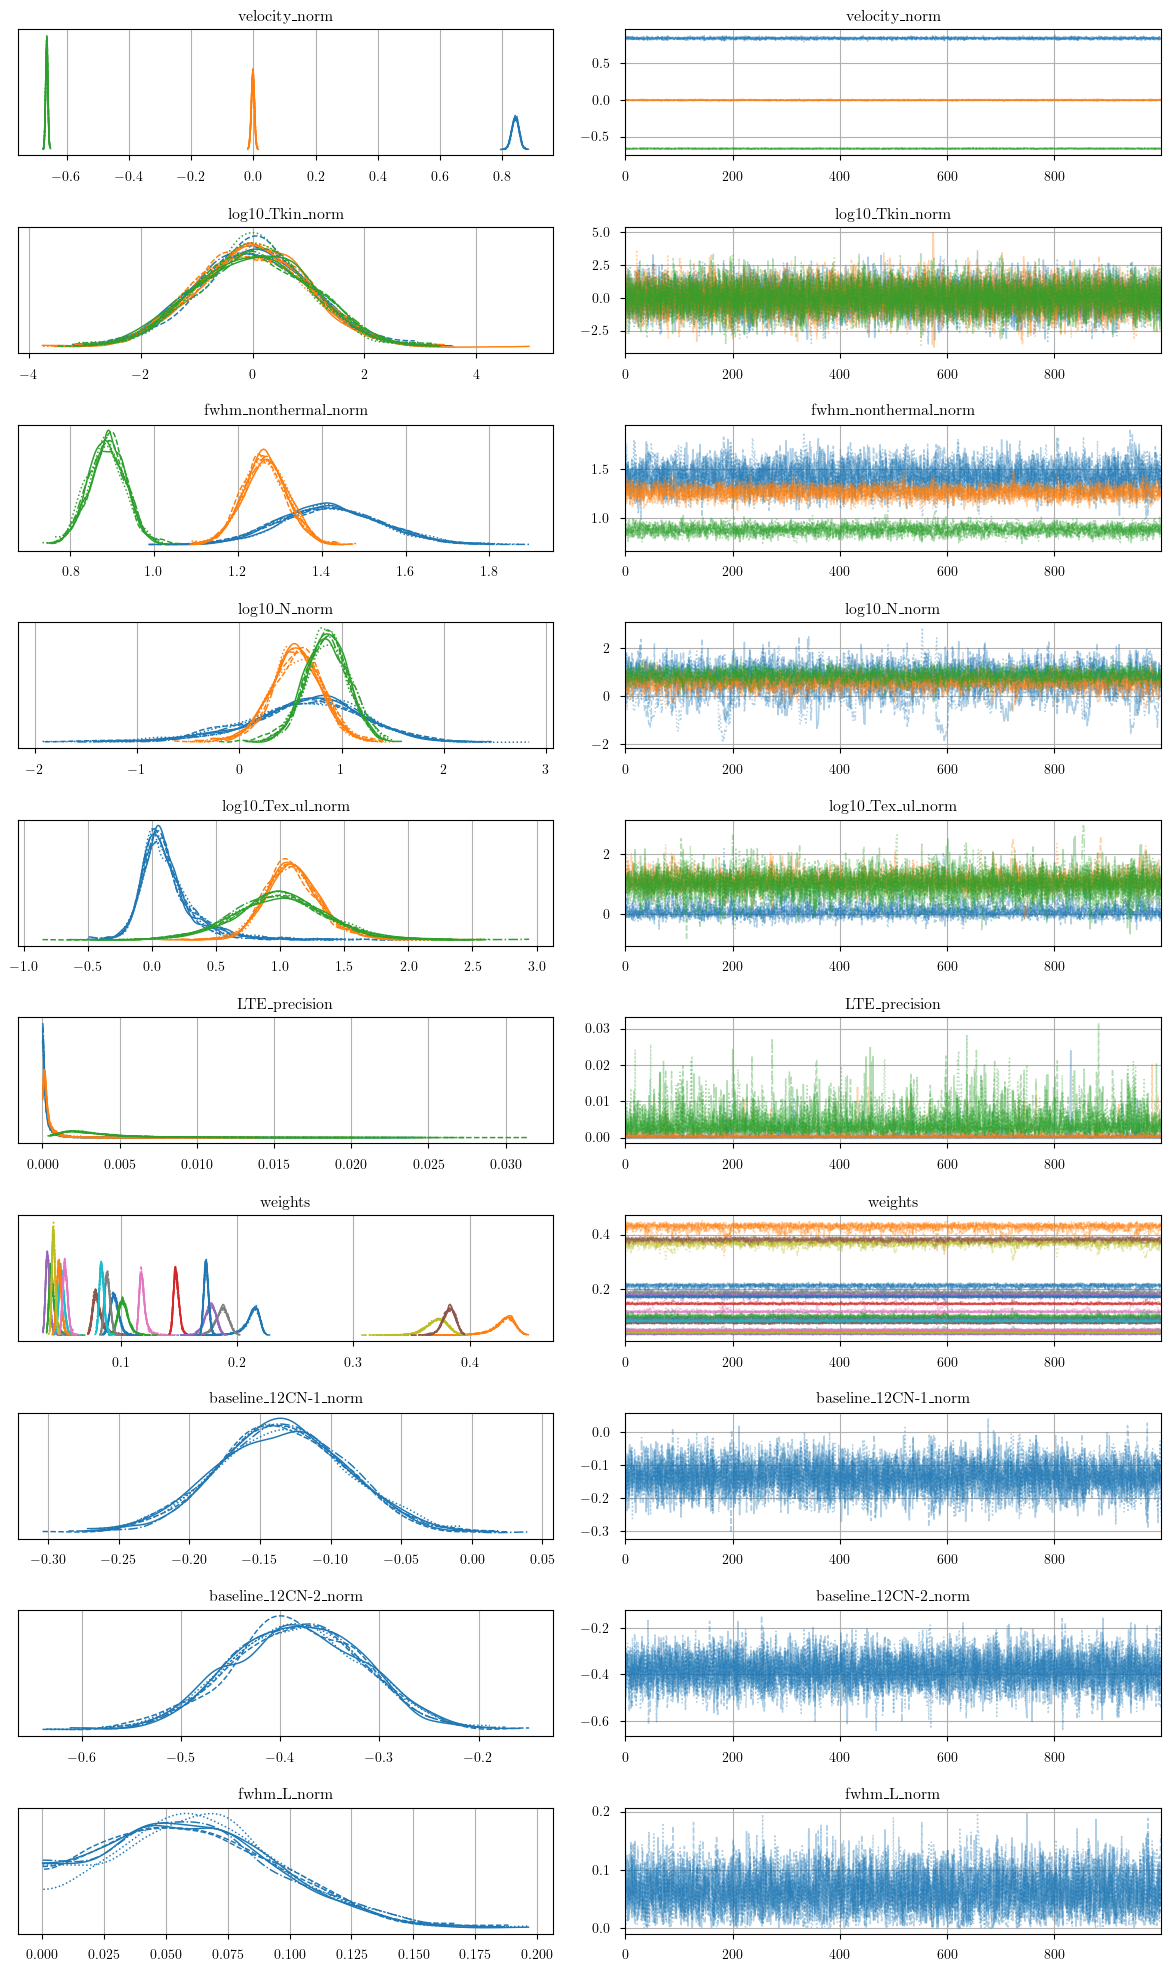

In [29]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


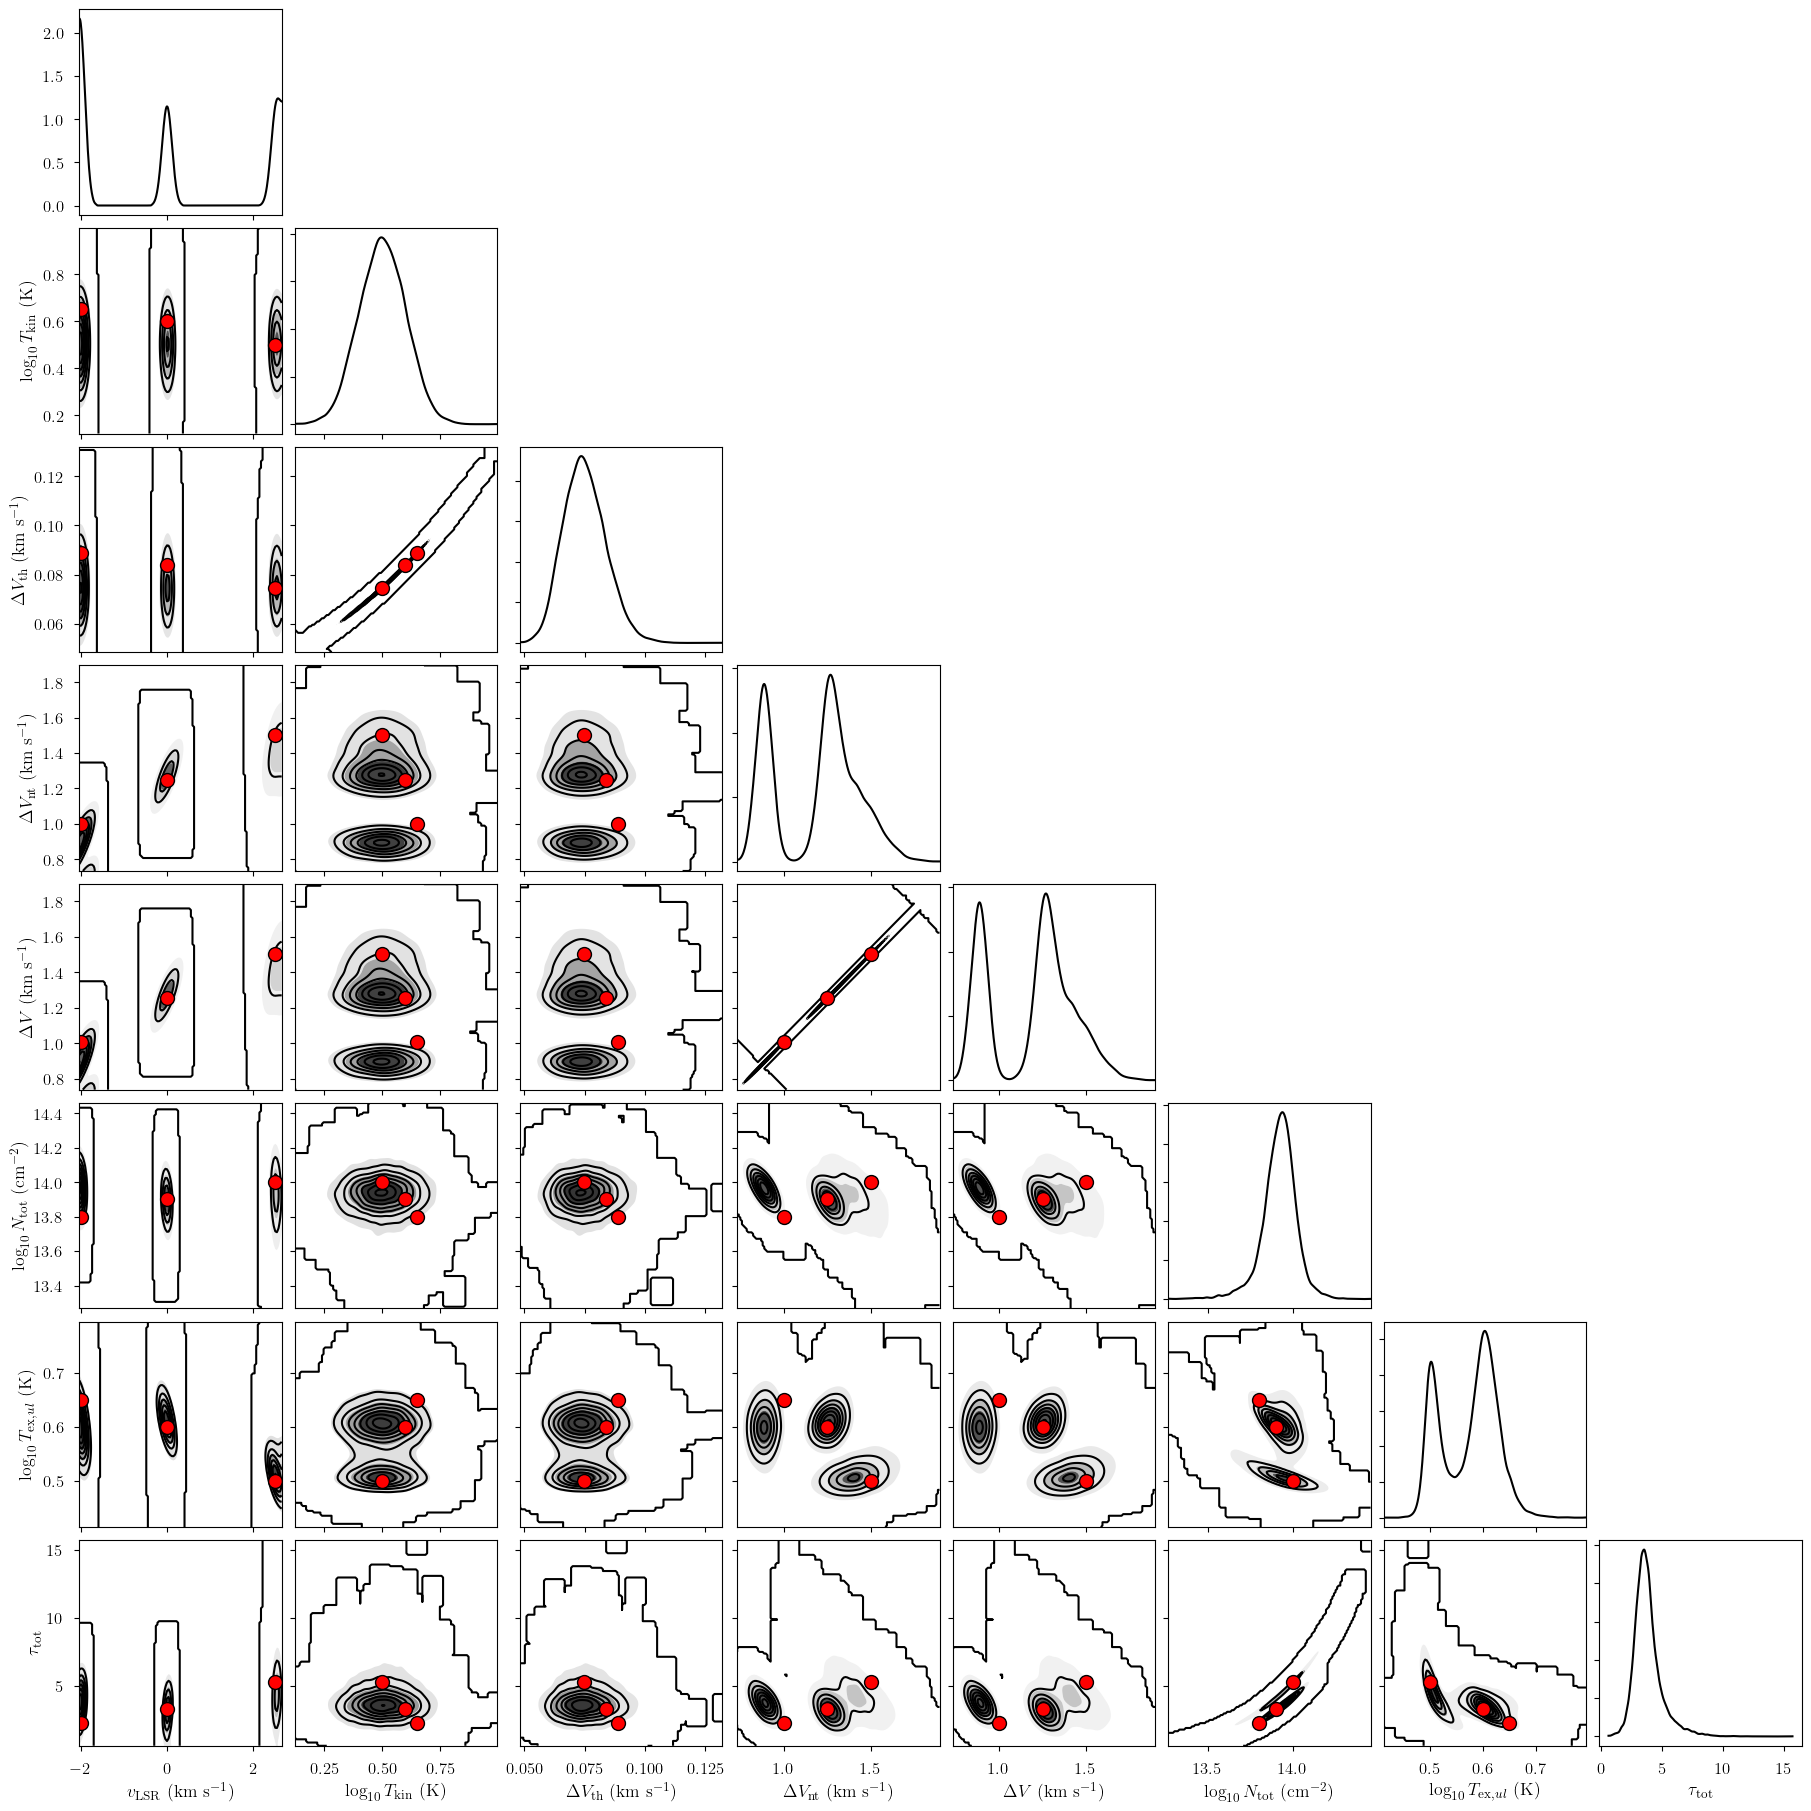

In [20]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


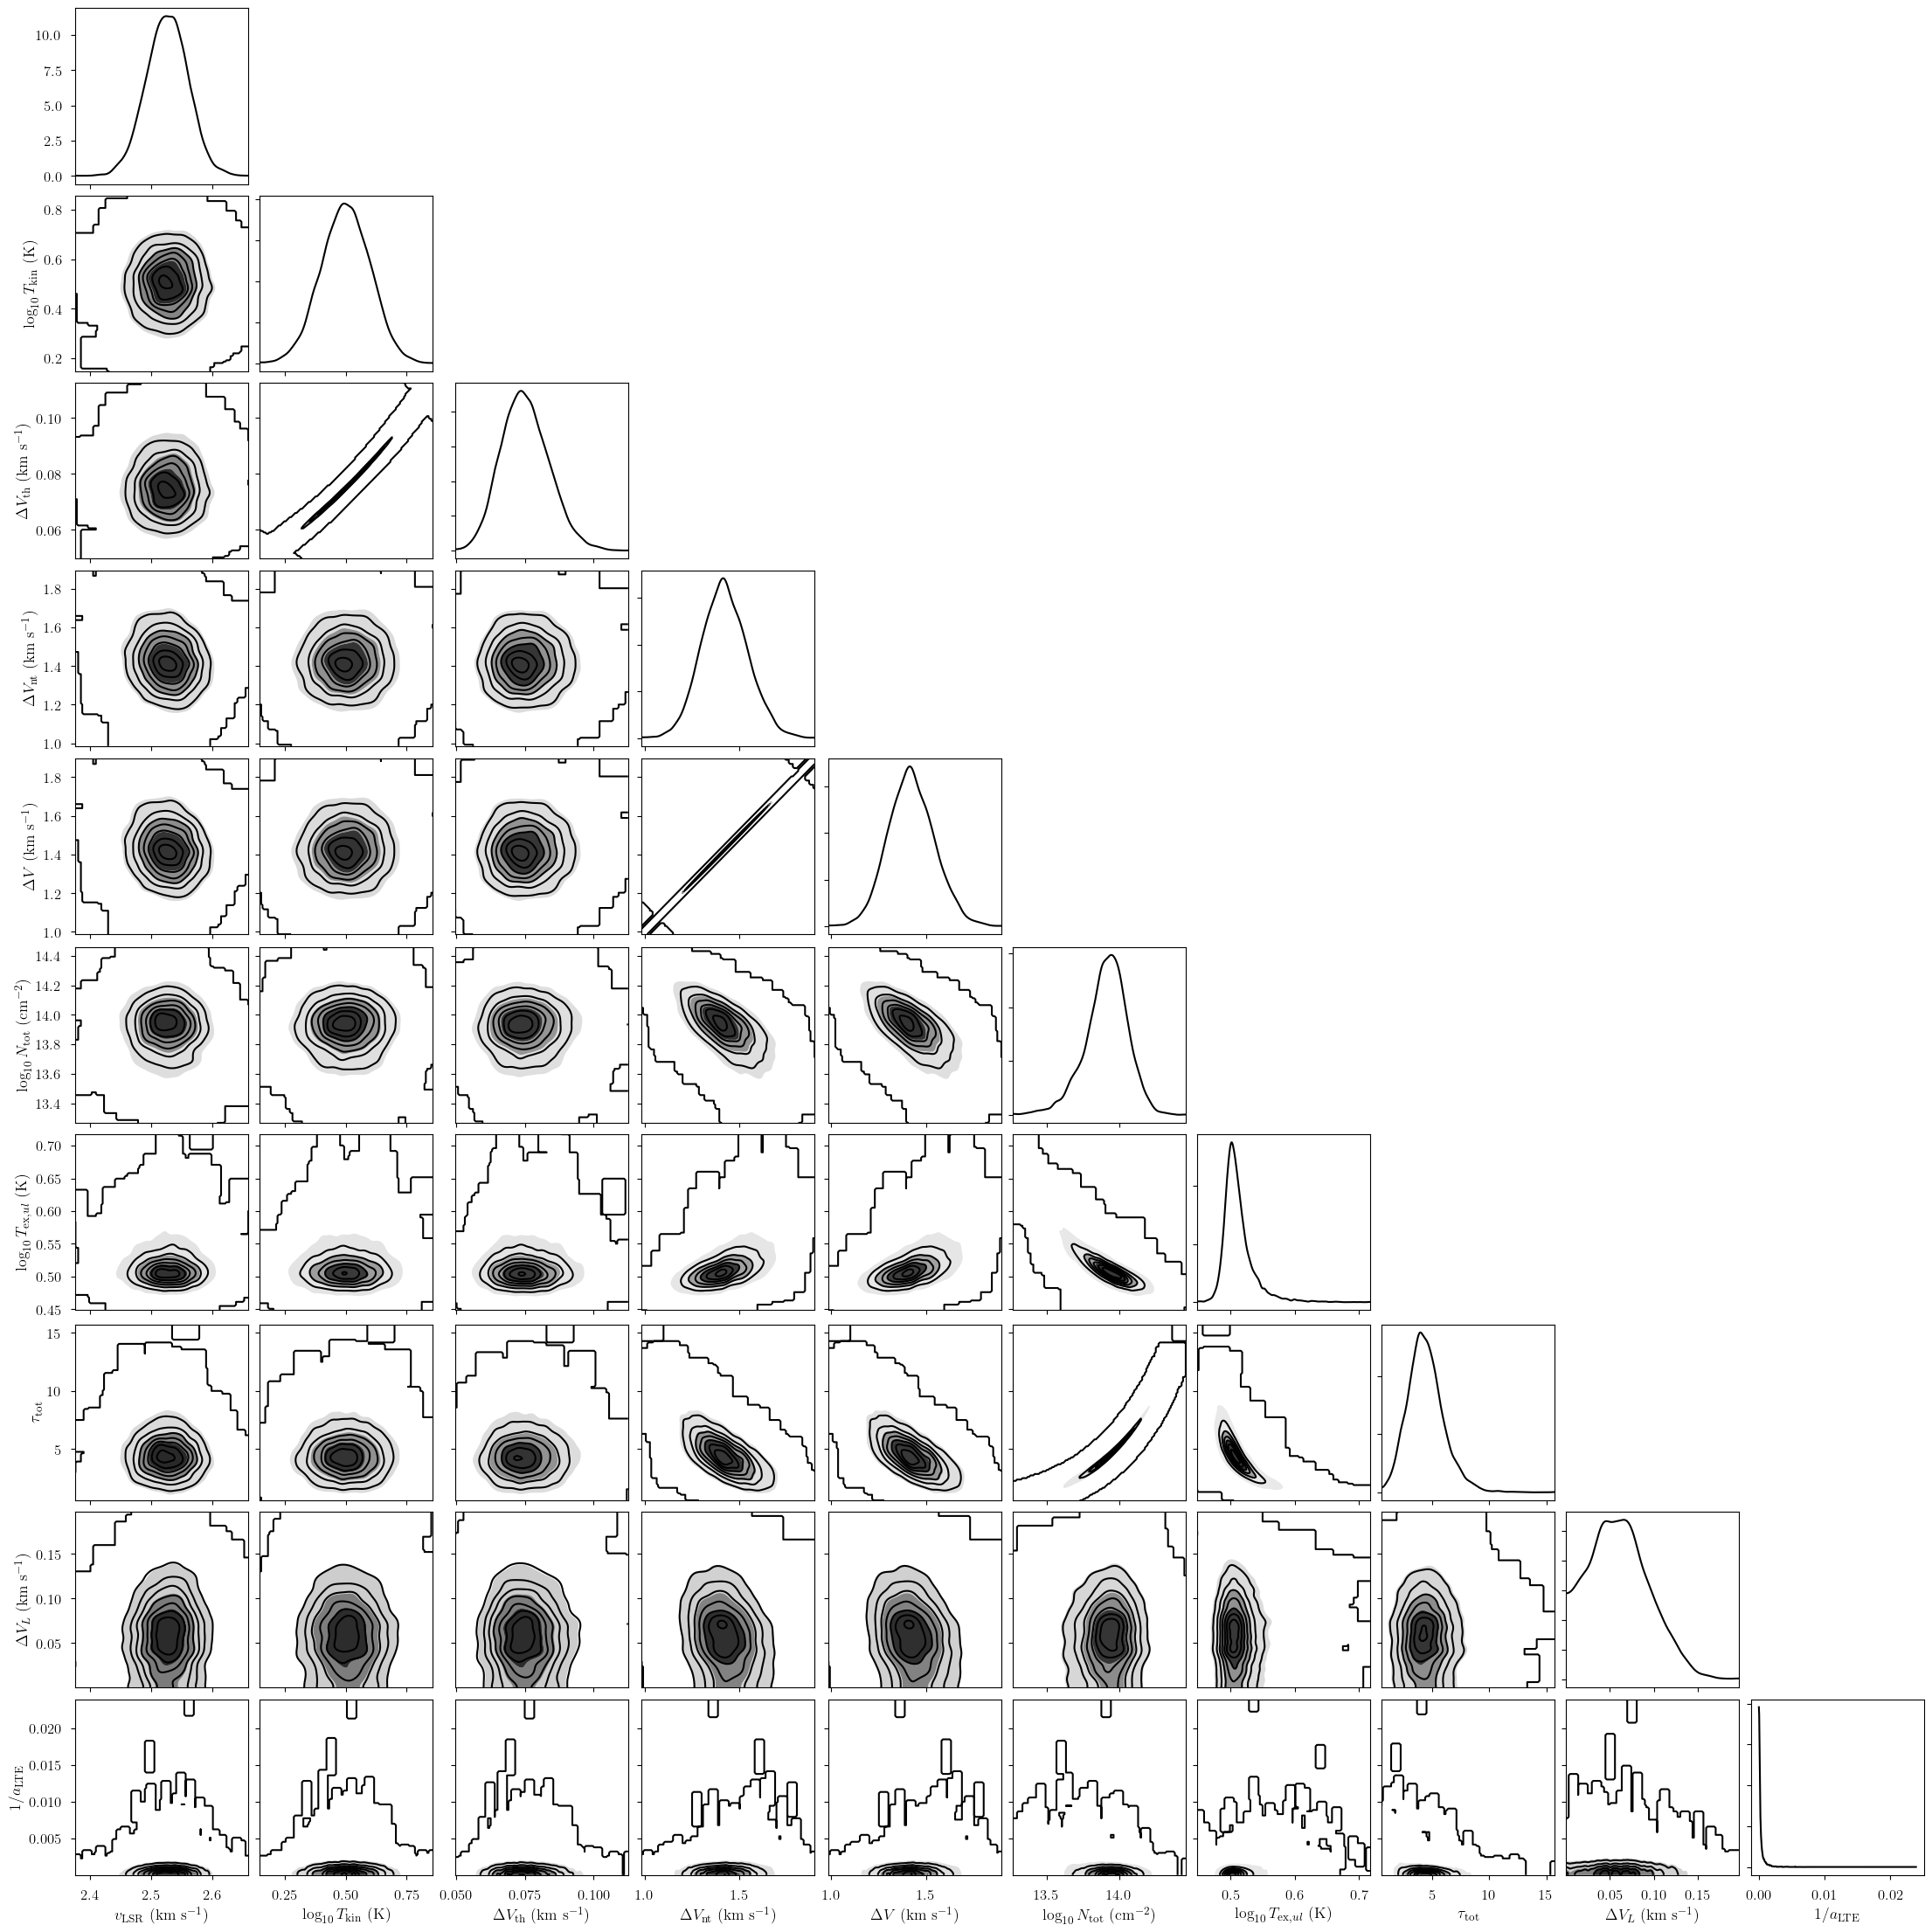

In [26]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics + ["LTE_precision"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)

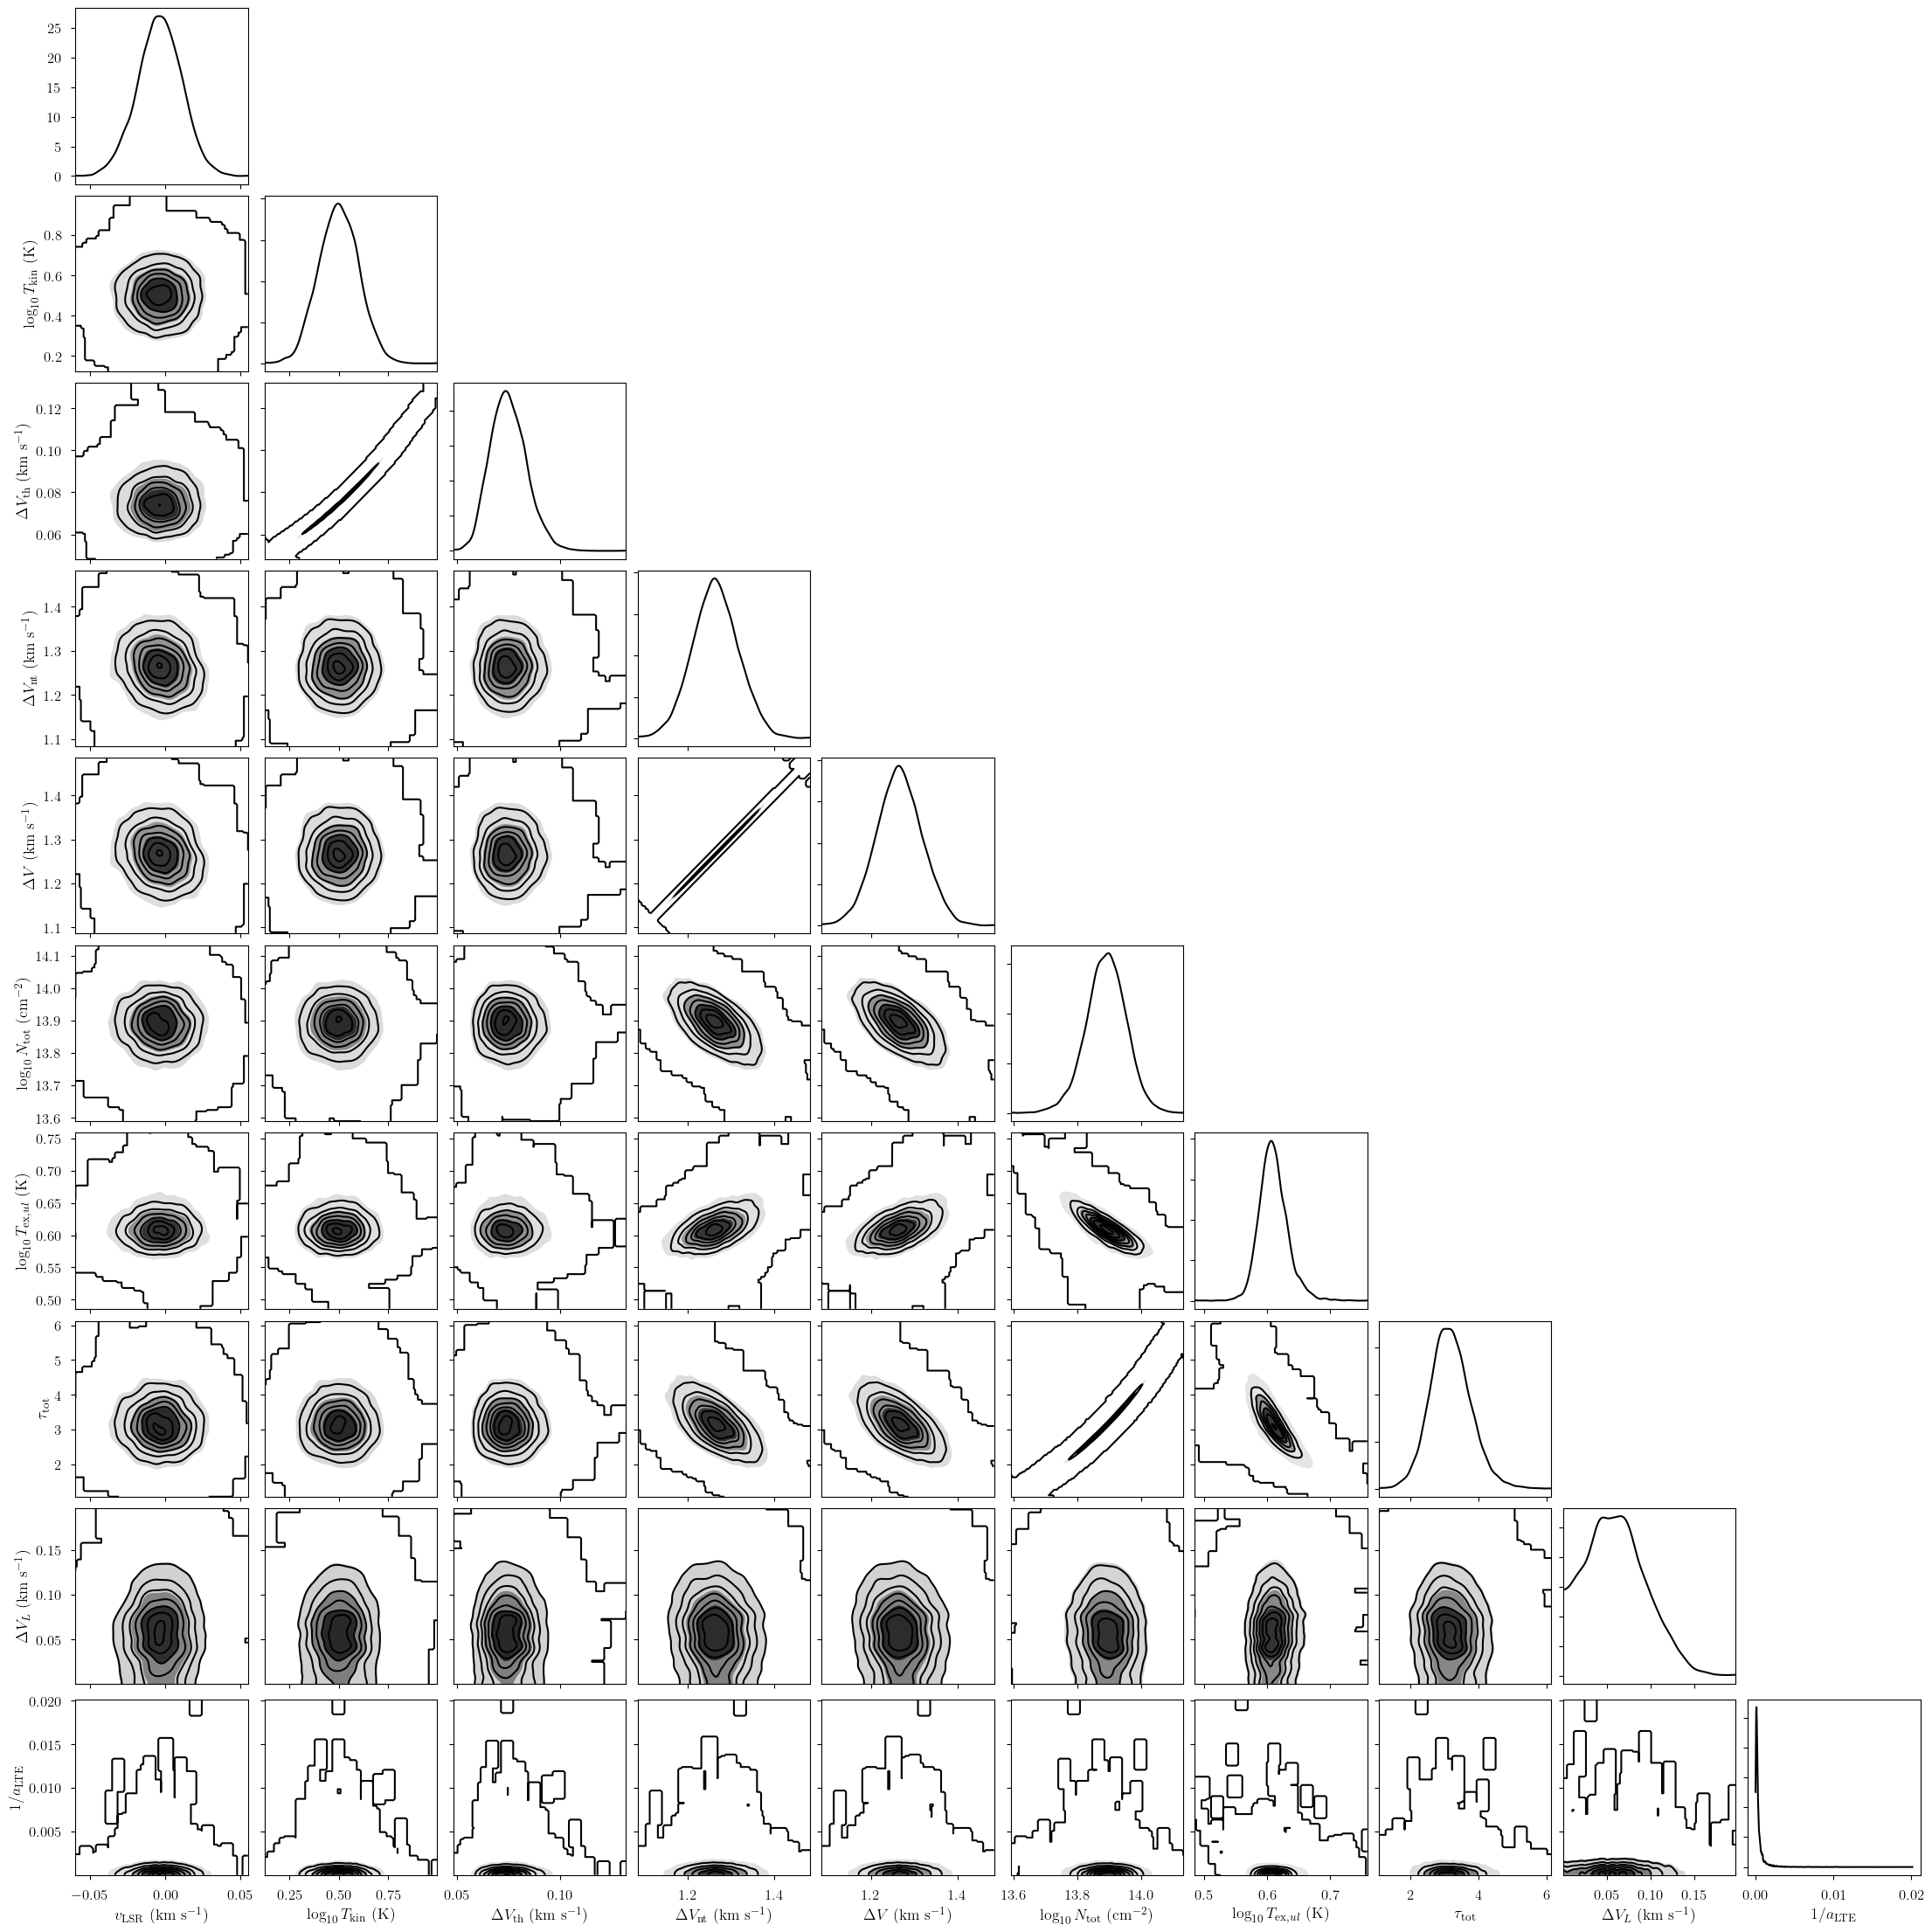

In [27]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics + ["LTE_precision"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)

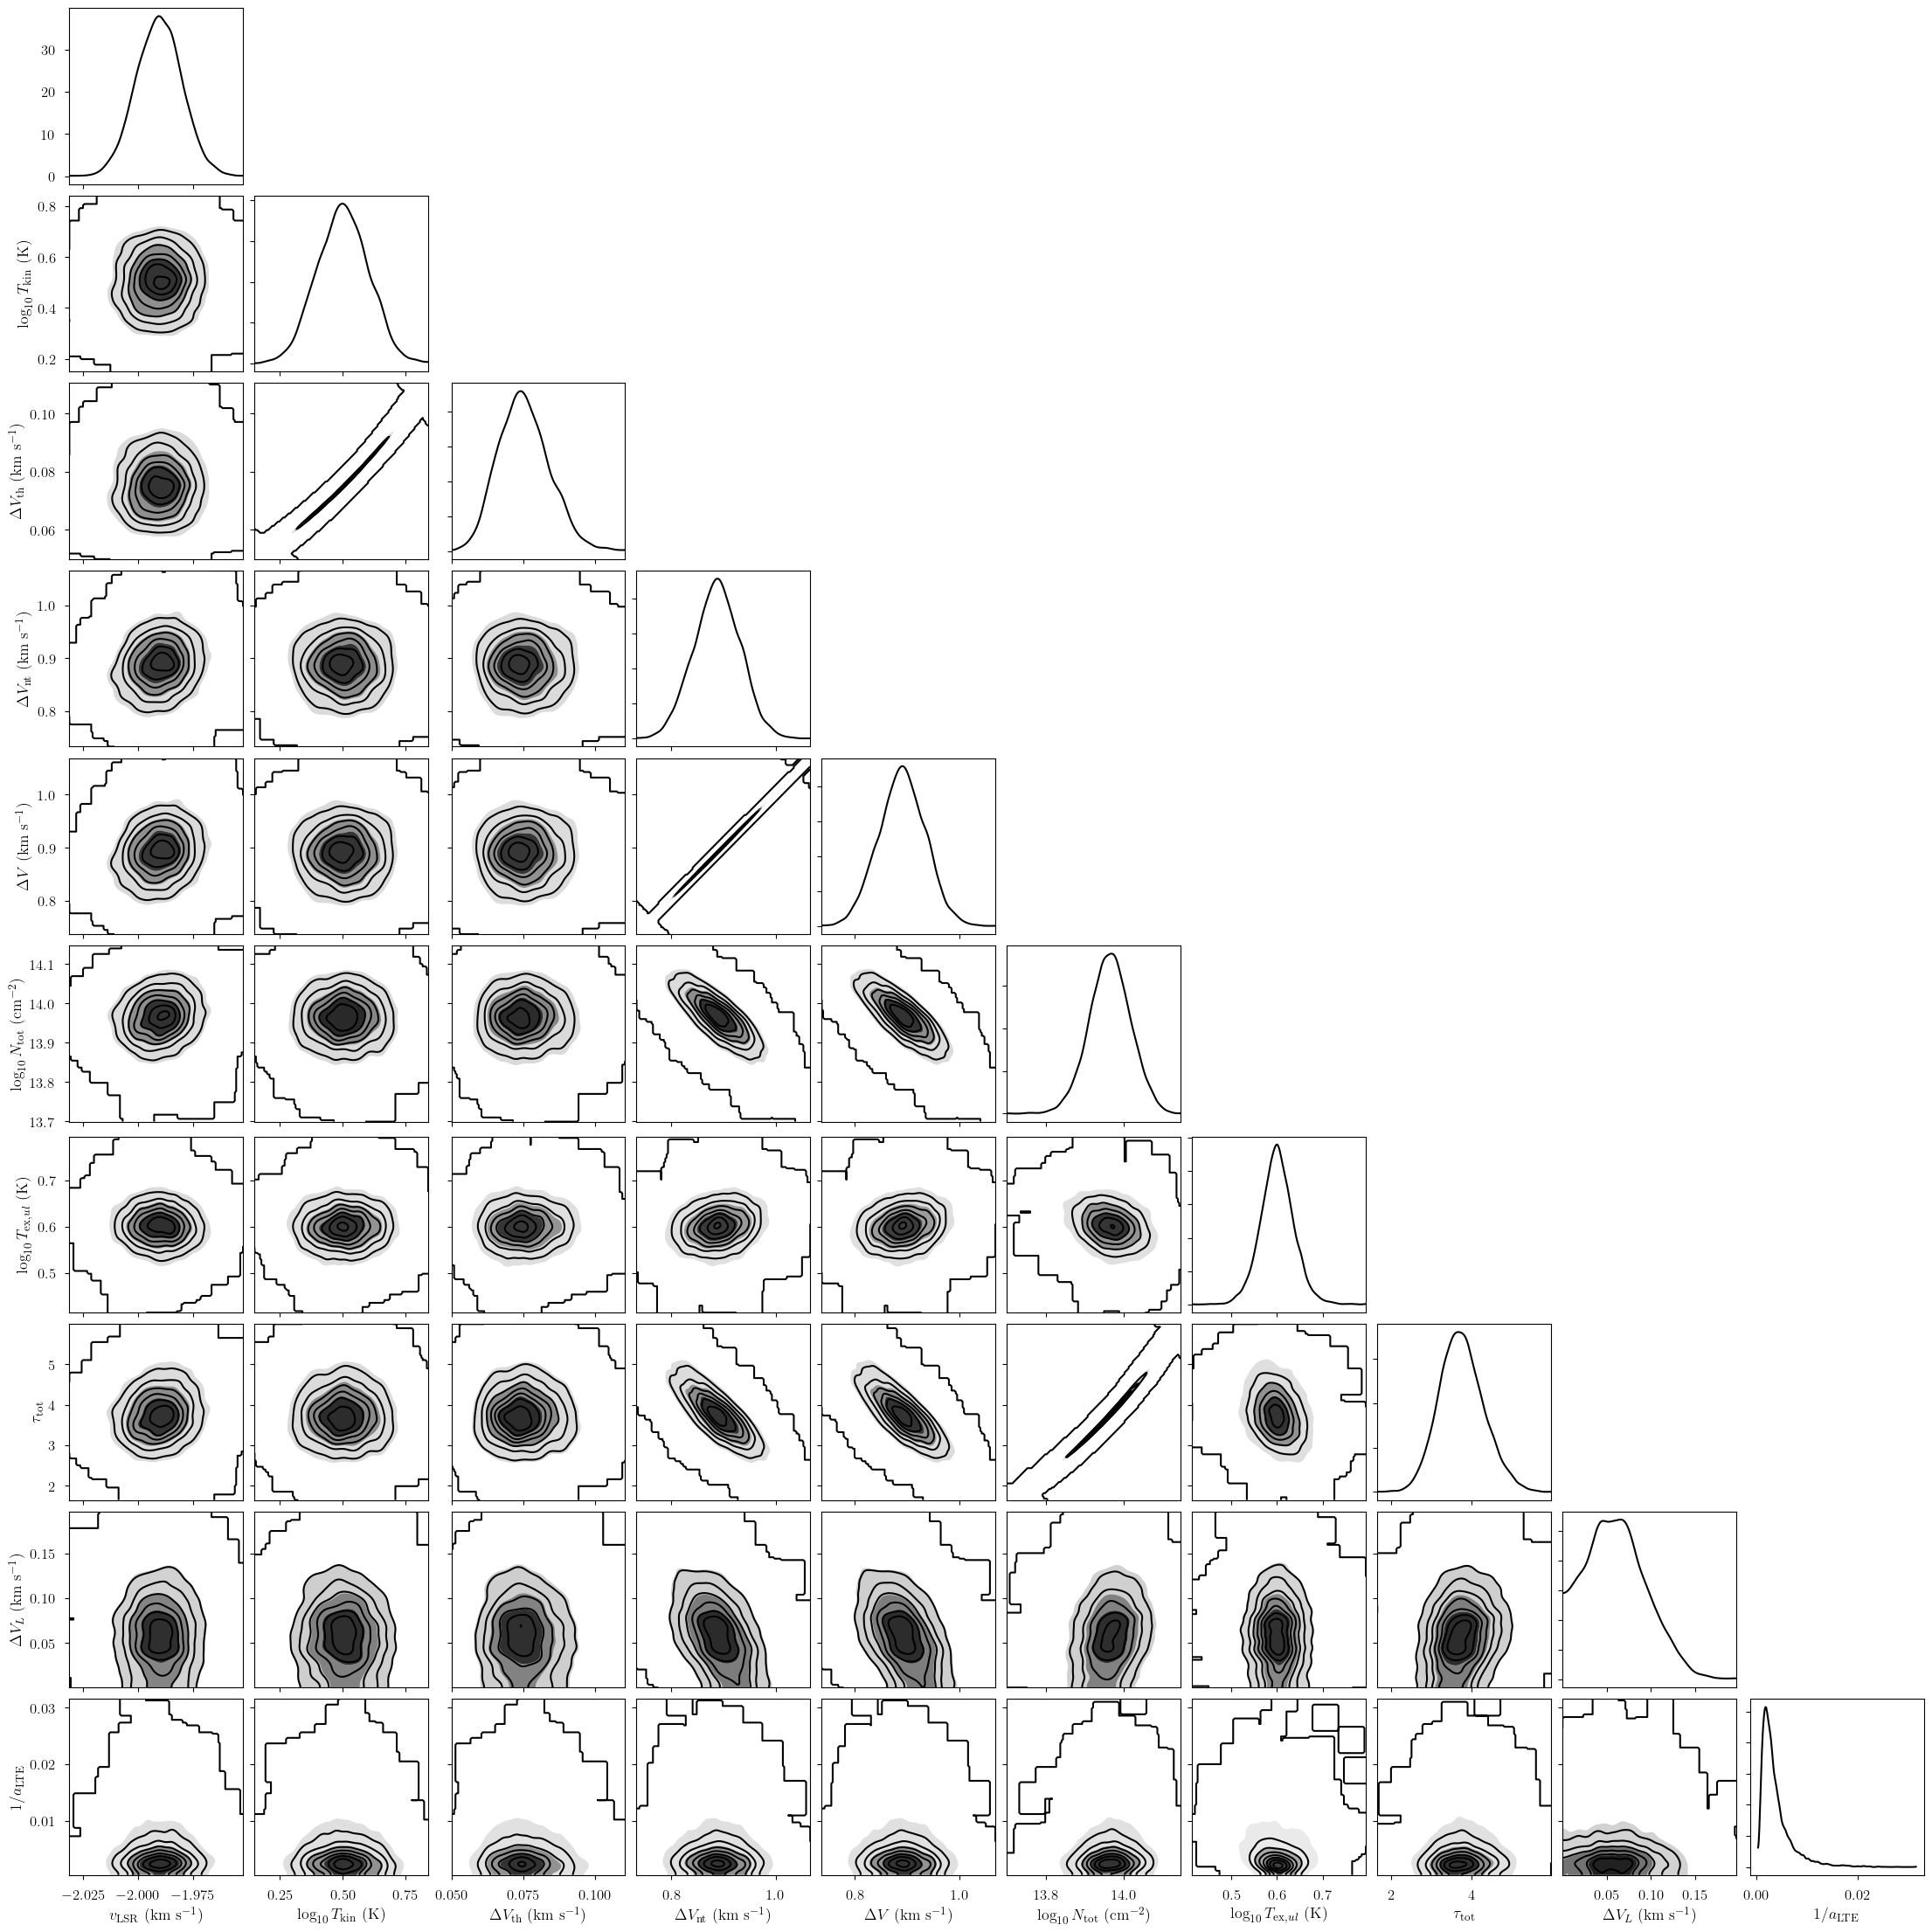

In [28]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + model.hyper_deterministics + ["LTE_precision"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)

In [24]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics + ["LTE_precision"]
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3294.9594842487136


mean     sd  hdi_16%  hdi_84%
velocity[0]               2.527  0.034    2.491    2.558
velocity[1]              -0.004  0.015   -0.018    0.011
velocity[2]              -1.990  0.010   -2.001   -1.981
log10_Tkin[0]             0.500  0.100    0.403    0.602
log10_Tkin[1]             0.499  0.101    0.397    0.596
log10_Tkin[2]             0.502  0.102    0.393    0.597
fwhm_thermal[0]           0.075  0.009    0.067    0.084
fwhm_thermal[1]           0.075  0.009    0.065    0.083
fwhm_thermal[2]           0.075  0.009    0.066    0.083
fwhm_nonthermal[0]        1.422  0.122    1.284    1.524
fwhm_nonthermal[1]        1.264  0.053    1.209    1.314
fwhm_nonthermal[2]        0.887  0.044    0.848    0.937
fwhm[0]                   1.424  0.122    1.298    1.537
fwhm[1]                   1.266  0.053    1.212    1.317
fwhm[2]                   0.891  0.044    0.852    0.941
log10_N[0]               13.911  0.147   13.788   14.056
log10_N[1]               13.889  0.064   13.832   13.953
log10_N[2]               13.964  0.053   13.910   14.014
log10_Tex_ul[0]           0.512  0.024    0.489    0.521
log10_Tex_ul[1]           0.610  0.023    0.589    0.630
log10_Tex_ul[2]           0.600  0.037    0.566    0.635
Tex[113123.3687, 0]       3.343  0.282    3.096    3.395
Tex[113123.3687, 1]       4.092  0.249    3.815    4.241
Tex[113123.3687, 2]       4.480  0.251    4.203    4.655
Tex[113144.19, 0]         3.319  0.241    3.096    3.372
Tex[113144.19, 1]         4.111  0.240    3.860    4.260
Tex[113144.19, 2]         4.207  0.173    4.017    4.336
Tex[113170.535, 0]        3.293  0.238    3.080    3.338
Tex[113170.535, 1]        3.973  0.208    3.750    4.105
Tex[113170.535, 2]        3.932  0.150    3.757    4.029
Tex[113191.325, 0]        3.270  0.204    3.077    3.321
Tex[113191.325, 1]        3.992  0.203    3.785    4.132
Tex[113191.325, 2]        3.722  0.104    3.603    3.798
Tex[113488.142, 0]        3.291  0.233    3.077    3.336
Tex[113488.142, 1]        4.223  0.252    3.952    4.372
Tex[113488.142, 2]        3.786  0.127    3.645    3.877
Tex[113490.985, 0]        3.234  0.112    3.127    3.259
Tex[113490.985, 1]        4.115  0.129    3.984    4.200
Tex[113490.985, 2]        4.562  0.083    4.469    4.619
Tex[113499.643, 0]        3.153  0.175    2.991    3.217
Tex[113499.643, 1]        3.969  0.212    3.752    4.121
Tex[113499.643, 2]        3.814  0.140    3.661    3.917
Tex[113508.934, 0]        3.270  0.203    3.086    3.331
Tex[113508.934, 1]        4.244  0.251    3.975    4.388
Tex[113508.934, 2]        3.592  0.092    3.488    3.660
Tex[113520.4215, 0]       3.134  0.158    2.984    3.211
Tex[113520.4215, 1]       3.989  0.217    3.755    4.129
Tex[113520.4215, 2]       3.618  0.112    3.492    3.704
tau[113123.3687, 0]       0.053  0.019    0.033    0.069
tau[113123.3687, 1]       0.038  0.008    0.031    0.045
tau[113123.3687, 2]       0.041  0.007    0.033    0.047
tau[113144.19, 0]         0.437  0.157    0.273    0.564
tau[113144.19, 1]         0.312  0.060    0.253    0.367
tau[113144.19, 2]         0.374  0.057    0.315    0.426
tau[113170.535, 0]        0.425  0.154    0.267    0.554
tau[113170.535, 1]        0.312  0.060    0.250    0.364
tau[113170.535, 2]        0.350  0.056    0.286    0.394
tau[113191.325, 0]        0.557  0.199    0.361    0.730
tau[113191.325, 1]        0.401  0.076    0.324    0.467
tau[113191.325, 2]        0.502  0.073    0.427    0.569
tau[113488.142, 0]        0.553  0.201    0.348    0.722
tau[113488.142, 1]        0.395  0.077    0.311    0.458
tau[113488.142, 2]        0.464  0.073    0.381    0.522
tau[113490.985, 0]        1.485  0.521    0.981    1.946
tau[113490.985, 1]        1.052  0.191    0.858    1.220
tau[113490.985, 2]        1.213  0.172    1.033    1.367
tau[113499.643, 0]        0.443  0.159    0.280    0.577
tau[113499.643, 1]        0.321  0.062    0.257    0.375
tau[113499.643, 2]        0.365  0.058    0.301    0.413
tau[113508.934, 0]        0.431  0.15